### Load movie information and user rating

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2022)

font_size = 25
font_size_ticks = 22

rating_names = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(r'/home/buzgalbraith/work/school/spring_2023/probaility-theroy-2-2023/homework_code/homework_10/ml-100k/u.data', sep='\t', encoding='latin-1',names=rating_names)
movie_names = ['movie_id', 'title', 'release_date']
movies = pd.read_csv(r'/home/buzgalbraith/work/school/spring_2023/probaility-theroy-2-2023/homework_code/homework_10/ml-100k/u.item', sep='|', names=movie_names,usecols=range(3),
                     encoding='latin-1')
data = pd.merge(movies,ratings)
print(data.columns)
print(data.head(3))
print(data.title.value_counts()[:20])
print(data.user_id.value_counts()[:5])
print(data.rating.value_counts())

Index(['movie_id', 'title', 'release_date', 'user_id', 'rating', 'timestamp'], dtype='object')
   movie_id             title release_date  user_id  rating  timestamp
0         1  Toy Story (1995)  01-Jan-1995      308       4  887736532
1         1  Toy Story (1995)  01-Jan-1995      287       5  875334088
2         1  Toy Story (1995)  01-Jan-1995      148       4  877019411
Star Wars (1977)                    583
Contact (1997)                      509
Fargo (1996)                        508
Return of the Jedi (1983)           507
Liar Liar (1997)                    485
English Patient, The (1996)         481
Scream (1996)                       478
Toy Story (1995)                    452
Air Force One (1997)                431
Independence Day (ID4) (1996)       429
Raiders of the Lost Ark (1981)      420
Godfather, The (1972)               413
Pulp Fiction (1994)                 394
Twelve Monkeys (1995)               392
Silence of the Lambs, The (1991)    390
Jerry Maguire (1996) 

### Transform the ratings of selected users and movies into a matrix, and center the ratings

In [3]:
n_movies = 100
n_users = 1000
movies = data.title.value_counts()[:n_movies].index.tolist()
users = np.array(data.user_id.value_counts()[:n_users].index.tolist())

rating_matrix = np.zeros((n_movies,n_users))
n_ratings = 0
for ind,movie in enumerate(movies):
    ratings = data[data["title"] == movie]
    rating_matrix[ind,:]= np.mean(ratings['rating']) # Impute mean rating for that movie for all missing ratings
    for index, row in ratings.iterrows():
        user_id = row['user_id']
        if user_id in users:
            rating_matrix[ind,np.where(users == user_id)]= row['rating']
            # print(movie + " user: " + str(user_id) + " rating: " + str(row['rating']))
            n_ratings += 1
print(str(n_ratings) + " observed ratings out of " + str(n_movies*n_users))
print(rating_matrix[:5,:5])
mean_rating = np.mean(rating_matrix)
print(mean_rating)
centered_matrix = rating_matrix - mean_rating

30055 observed ratings out of 100000
[[5.         4.         5.         5.         5.        ]
 [3.80353635 2.         4.         4.         5.        ]
 [4.15551181 3.         5.         4.         5.        ]
 [5.         3.         5.         4.         5.        ]
 [3.15670103 3.         2.         4.         4.        ]]
3.817224013722978


## (a) Preprocessing
### Shuffle the nonzero ratings and split into train, validation, and test set
Hint: np.flatnonzero() and np.flat() may be helpful to transform the rating matrix

In [6]:
n_test = 1000
n_val = 1000
n_train = n_ratings - n_test - n_val
full_rating_matrix = np.zeros((n_movies,n_users))
for ind,movie in enumerate(movies):
    ratings = data[data["title"] == movie]
    for index, row in ratings.iterrows():
        user_id = row['user_id']
        if user_id in users:
            full_rating_matrix[ind,np.where(users == user_id)]= row['rating']

# Split train, val, test ratings from nonzero ratings
nonmissing_indices = np.flatnonzero(full_rating_matrix > 0.1)
aux_ind = nonmissing_indices[np.random.permutation(np.arange(len(nonmissing_indices)))]
test_ind = aux_ind[:n_test]
val_ind = aux_ind[n_test:(n_test+n_val)]
train_ind = aux_ind[(n_test+n_val):(n_test+n_val+n_train)]

train_ratings = full_rating_matrix.flat[train_ind]        
val_ratings = full_rating_matrix.flat[val_ind]
test_ratings = full_rating_matrix.flat[test_ind]

### Imputing missing ratings with the mean of each movie

In [8]:
# make imputed rating matrix (training data) as initialization
rating_matrix_ini = np.zeros(full_rating_matrix.shape)
rating_matrix_ini.flat[train_ind] = train_ratings
mean_rating_movie = np.zeros(n_movies)

# Impute mean rating of each movie to fill missing ratings
for ind_movie in range(rating_matrix_ini.shape[0]):
    # non_zero_index=np.nonzero(rating_matrix_ini[:,ind_movie])
    # movie_mean = np.mean(rating_matrix[non_zero_index, ind_movie])
    # rating_matrix_ini[ind_movie,rating_matrix_ini[ind_movie,:]==0] = movie_mean
    mean_rating = rating_matrix_ini[ind_movie, np.nonzero(rating_matrix_ini[ind_movie])].mean()
    rating_matrix_ini[ind_movie, np.argwhere(rating_matrix_ini[ind_movie]==0).flatten()] = mean_rating
# show part of the matrix
print(rating_matrix_ini[:3,:3])

[[5.         4.         5.        ]
 [3.80543933 2.         4.        ]
 [4.1627907  3.         5.        ]]


In [ ]:
train_ratings

array([4., 3., 4., ..., 3., 1., 3.])

## (b) Low rank model
### Implement an algorithm to fit the low rank model

* Update the low rank estimation with ratings of training data in each iteration
* Compute root mean square errors (RMSE) between low rank estimation and training ratings
* Iterate the low-rank estimation until the loss converges to zeros

In [10]:
def fit_low_rank_model(rank,rating_matrix_ini,train_ind,train_data,n_iter,convergence_thresh,verbose):
    """Fit the low rank model. 
    Return the estimation of the low rank model - (n_movies * n_users) matrix

    Keyword arguments:
    rank -- the rank of low rank model
    rating_matrix_ini -- imputed initialization
    train_ind -- index of training data
    train_data -- ratings of training set
    n_iter -- the max number of iterations
    convergence_thresh -- the threshold of convergence to 0
    """
    previous_fitting_error = 100
    centerd_data=rating_matrix_ini-np.mean(rating_matrix_ini)
    u,s,v=np.linalg.svd(centerd_data)
    low_rank_estimate =np.mean(rating_matrix_ini) + u[:, :rank] @ np.diag(s[:rank]) @ v[:rank, :]
    
    for ind in range(n_iter):
        # Updates
        # TODO
        
        # Compute error
        fitting_error = np.sqrt( np.mean((low_rank_estimate.flat[train_ind]- train_data)**2) )
        centerd_data=low_rank_estimate-np.mean(low_rank_estimate)
        u,s,v=np.linalg.svd(centerd_data)
        low_rank_estimate =np.mean(low_rank_estimate) + u[:, :rank] @ np.diag(s[:rank]) @ v[:rank, :]

        if verbose:
            print("Iteration " + str(ind) + " Error: " + str(fitting_error))
        
        # Stopping criterion
        #TODO
        if(fitting_error <= convergence_thresh):
            break
    return low_rank_estimate

n_iter = 5
convergence_thresh = 1e-4
verbose = True
rank = 20
estimate =fit_low_rank_model(rank,rating_matrix_ini,train_ind,train_ratings,n_iter,convergence_thresh,verbose)
estimate[:3,:3]
print(rating_matrix_ini[:3,:3])
print(estimate[:3,:3])

Iteration 0 Error: 0.6549908995952204
Iteration 1 Error: 0.6549911269534475
Iteration 2 Error: 0.6549911275005221
Iteration 3 Error: 0.654991127501838
Iteration 4 Error: 0.6549911275018413
[[5.         4.         5.        ]
 [3.80543933 2.         4.        ]
 [4.1627907  3.         5.        ]]
[[5.14199733 4.29148791 4.91634151]
 [3.36528609 2.07002213 3.40849063]
 [6.47619509 3.14284894 4.49061721]]


### Fit the low rank model with ranks from 1 to 10. Report and plot the training errors and validation errors.

In [11]:
ranks = np.arange(1,10,1)
train_error = np.zeros(len(ranks))
val_error = np.zeros(len(ranks))

n_iter = 500
convergence_thresh = 1e-4
verbose = False

for ind,rank in enumerate(ranks):
    print("Rank " + str(rank))
    estimate = fit_low_rank_model(rank,rating_matrix_ini,train_ind,train_ratings,n_iter,convergence_thresh,verbose)
    train_error[ind] =np.sqrt(np.mean((estimate.flat[train_ind]- train_ratings)**2))
    val_error[ind] = np.sqrt(np.mean((estimate.flat[val_ind]- val_ratings)**2))

Rank 1
Rank 2
Rank 3
Rank 4
Rank 5
Rank 6
Rank 7
Rank 8
Rank 9


[0.94965786 0.90187328 0.89557084 0.89273514 0.88667284 0.88384464
 0.88613393 0.88030803 0.88572836]
[0.95669682 0.89817691 0.87318474 0.85547257 0.83701049 0.82082463
 0.80767694 0.79393648 0.78171818]


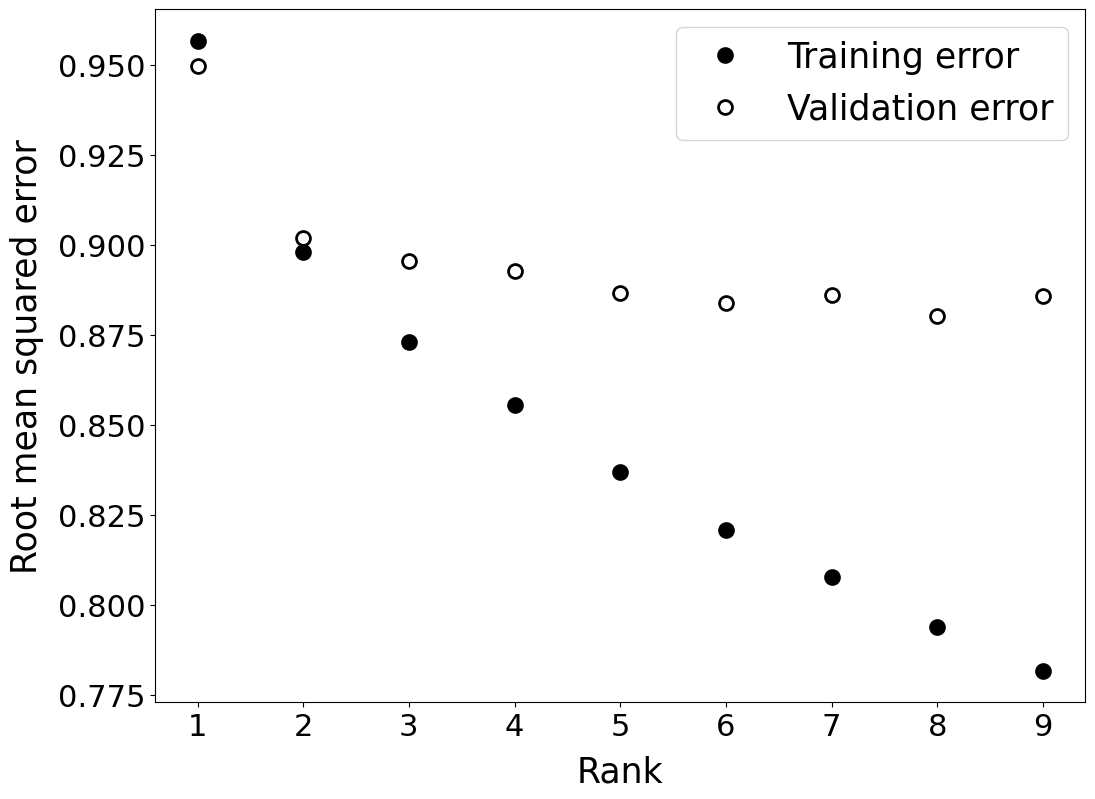

In [12]:
markersize = 10
plt.figure(figsize=(12,9))
plt.plot(ranks,train_error,linestyle="None",marker='o',ms=markersize,color="black",markeredgewidth=2,
                     markerfacecolor="black",label="Training error")
plt.plot(ranks,val_error,linestyle="None",marker='o',ms=markersize,color="black",markeredgewidth=2,
                     markerfacecolor="white",label="Validation error")
plt.ylabel('Root mean squared error',fontsize=font_size,labelpad=10)
plt.xlabel('Rank',fontsize=font_size,labelpad=10)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
#plt.ylim([0,1.1])
plt.legend(fontsize=font_size)
print(val_error)
print(train_error)
plt.show()
#plt.savefig('plots/collaborative_filtering_errors.pdf',bbox_inches="tight")

## (c) Evaluation
### What's the best rank (with least validation loss)? Report the test_error.

In [13]:
best_rank = 6
estimate = fit_low_rank_model(best_rank,rating_matrix_ini,train_ind,train_ratings,n_iter,convergence_thresh,verbose)
test_error = np.sqrt(np.mean((estimate.flat[test_ind]- test_ratings)**2))

print("Error of low-rank estimate: " + str(np.round(test_error,3)))

Error of low-rank estimate: 0.899


### If we estimate rating of each moive with the mean of its ratings (on training data), what's the test error? Compare with low rank model.

In [14]:
mean_rating_estimate = rating_matrix_ini
error_mean_rating =  np.sqrt(np.mean((mean_rating_estimate.flat[test_ind]- test_ratings)**2))
print("Error of mean-movie estimate: " + str(np.round(error_mean_rating,3)))

Error of mean-movie estimate: 0.977


## (d) Analysis
### Report top factors of the best low rank model estimate. What are 3 movies with highest and lowest magnitudes in each factor?


In [15]:
u,s,v=np.linalg.svd(estimate)
top_3_factors=s[:3]
top_3=np.argsort(u[:,1])[:3]
bottom_3=np.argsort(u[:,1])[-3:]
def get_top_and_bottom_movies_for_factor(estimate, factor_number):
    u,s,v=np.linalg.svd(estimate)
    top_3_factors=s[factor_number]
    print("for factor {0}\nthe top 3 movies are ".format(factor_number))
    top_3=np.argsort(u[:,factor_number])[:3]
    bottom_3=np.argsort(u[:,factor_number])[-3:]
    movies_1=np.array(movies)
    print(movies_1[top_3])
    print("bottom 3 movies are ")
    print(movies_1[bottom_3])
    

In [16]:
get_top_and_bottom_movies_for_factor(estimate, 0)

for factor 0
the top 3 movies are 
["Schindler's List (1993)" 'Shawshank Redemption, The (1994)'
 'Casablanca (1942)']
bottom 3 movies are 
['Evita (1996)' "Dante's Peak (1997)" 'Volcano (1997)']


In [27]:
import numpy as np
import cvxpy as cp

# Define the given matrix M and the matrix O with known and unknown entries
M = np.array([[np.nan, np.nan, 2, 0],
              [2, 2, 3, np.nan],
              [2, 3, 4, -2],
              [2, 4, np.nan, -3]])
print(M)


[[nan nan  2.  0.]
 [ 2.  2.  3. nan]
 [ 2.  3.  4. -2.]
 [ 2.  4. nan -3.]]


In [31]:

M_prime=(M-np.nanmean(M)).copy()
print(np.nanmean(M))
M_prime[np.isnan(M_prime)]=0
u,s,v=np.linalg.svd(M_prime)
print(s)

1.5833333333333333
[6.83544573 2.32414224 0.88036646 0.1290975 ]


In [35]:
a=np.nanmean(M)+s[0]*(u[:,0].reshape(-1,1) @ v[0,:].reshape(-1,1).T)
print(a)
np.linalg.matrix_rank(a)

[[ 1.81053551  2.27112884  2.06077989  0.36641163]
 [ 1.72804747  1.90203502  1.82257643  1.18253462]
 [ 2.06451703  3.40757241  2.79421076 -2.1464392 ]
 [ 2.12258981  3.66741983  2.96190946 -2.72100166]]


2

In [36]:
M[np.isnan(M)]=a[np.isnan(M)]
print(M)
np.linalg.matrix_rank(M)

[[ 1.71589676  2.17649009  2.          0.        ]
 [ 2.          2.          3.          1.08789586]
 [ 2.          3.          4.         -2.        ]
 [ 2.          4.          2.86727071 -3.        ]]


4

In [46]:
from surprise import Dataset
from surprise import SVD
from surprise import Reader
import pandas as pd

# Load the dataset with missing values
# df = pd.read_csv('matrix.csv')

# Set up the reader and load the data into a Surprise dataset

# Set up and fit the SVD algorithm
algo = SVD()
algo.fit(M)



AttributeError: 'numpy.ndarray' object has no attribute 'n_users'